In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
model = keras.models.load_model('convnet_from_scratch_with_augmentation')
model.summary()

2023-09-14 14:11:41.195613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 14:11:41.198743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 14:11:41.198840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [3]:
img_path = keras.utils.get_file(fname='cat.jpg', origin='https://img-datasets.s3.amazonaws.com/cat.jpg')

print(img_path)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    a = keras.utils.img_to_array(img)
    a = np.expand_dims(a, axis=0)
    return a

img_tensor = get_img_array(img_path, target_size=(180, 180))
img_tensor.shape

80329/80329 [==============================] - 0s 3us/step
/root/.keras/datasets/cat.jpg


(1, 180, 180, 3)

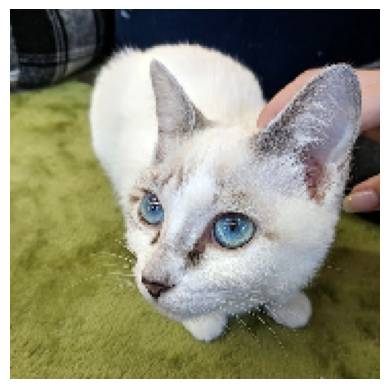

In [4]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img_tensor[0].astype(np.uint8))
plt.show()

In [5]:
layer_outputs = []
layer_names = []

for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.inputs, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 233ms/step


2023-09-14 14:11:43.265643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(1, 178, 178, 32)


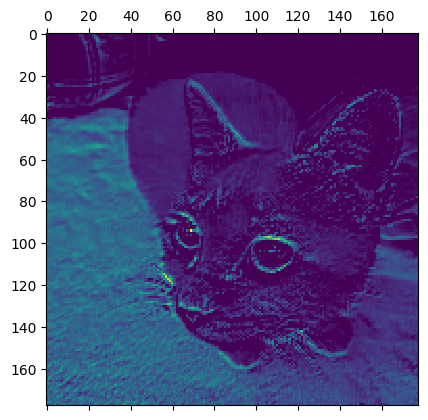

In [6]:
print(activations[0].shape)

plt.matshow(activations[0][0, :, :, 5], cmap='viridis')

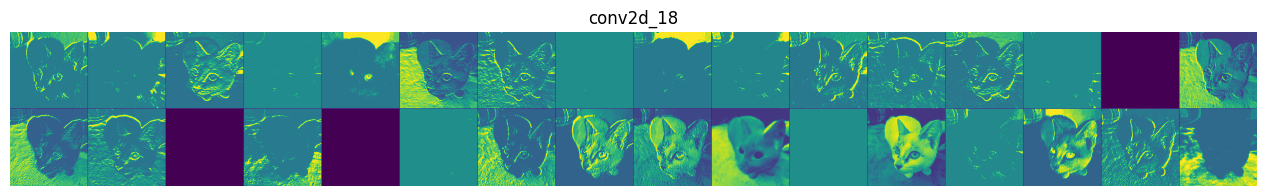

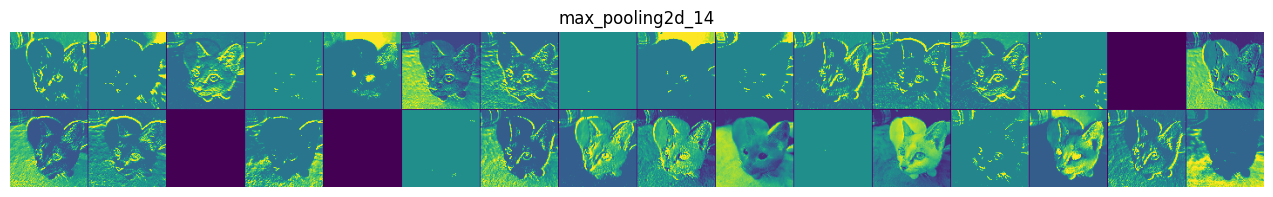

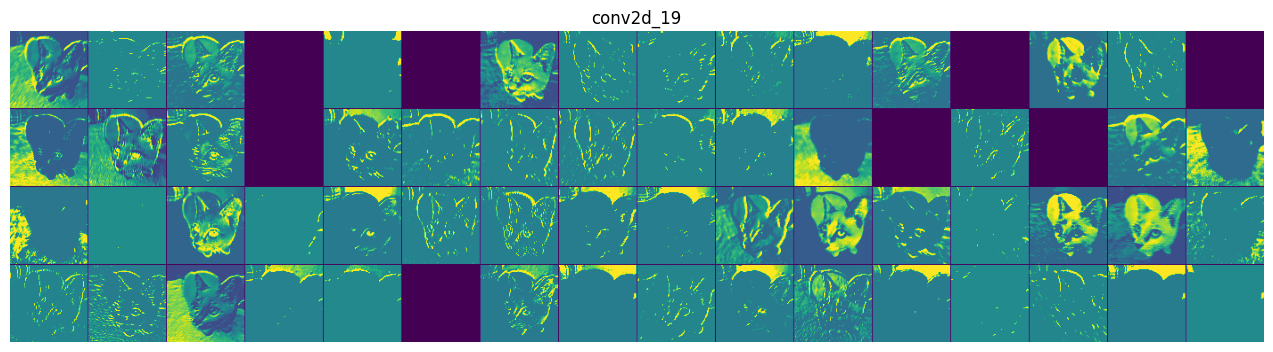

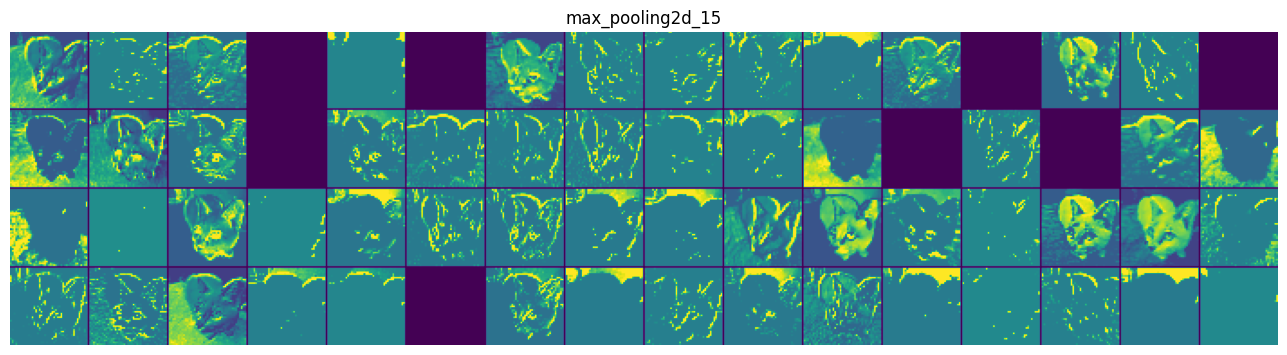

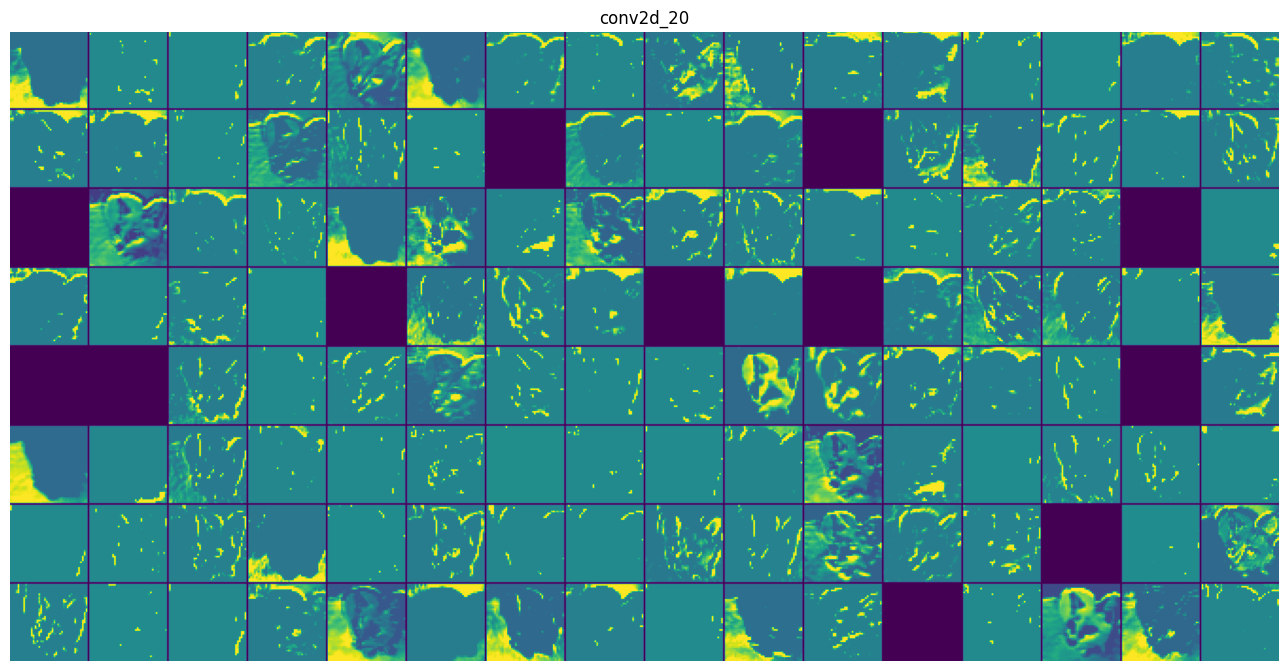

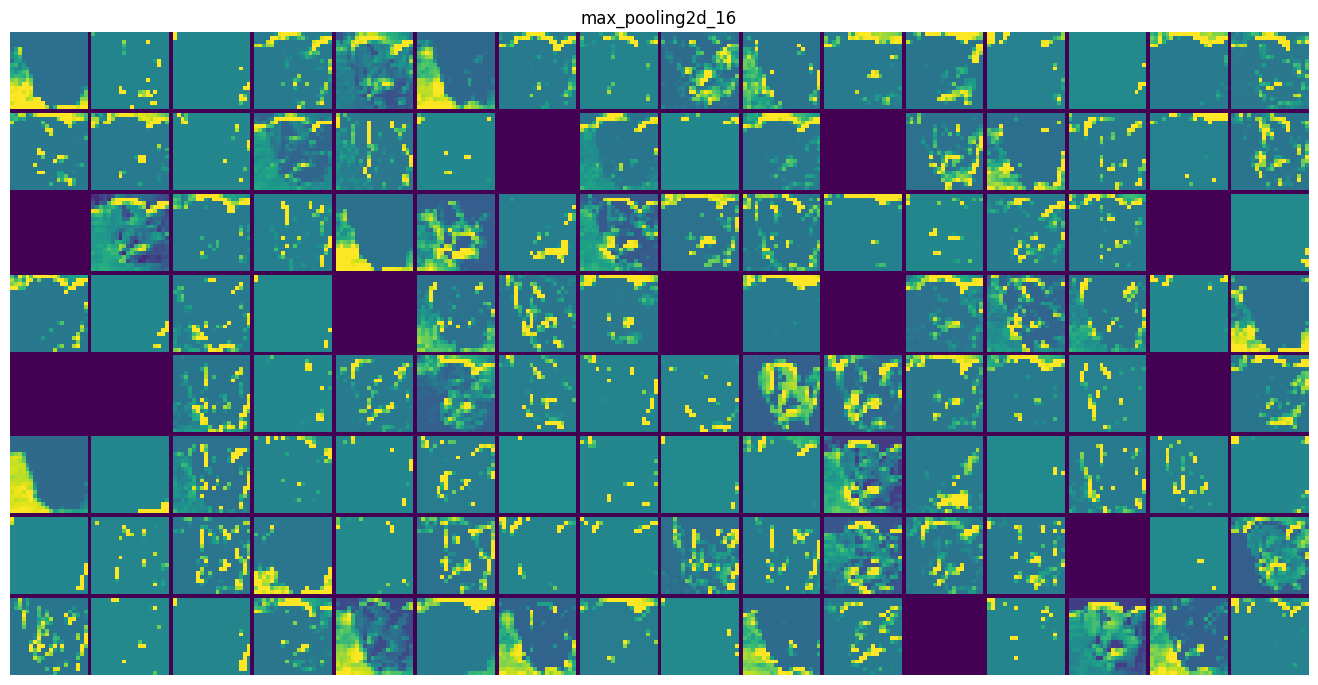

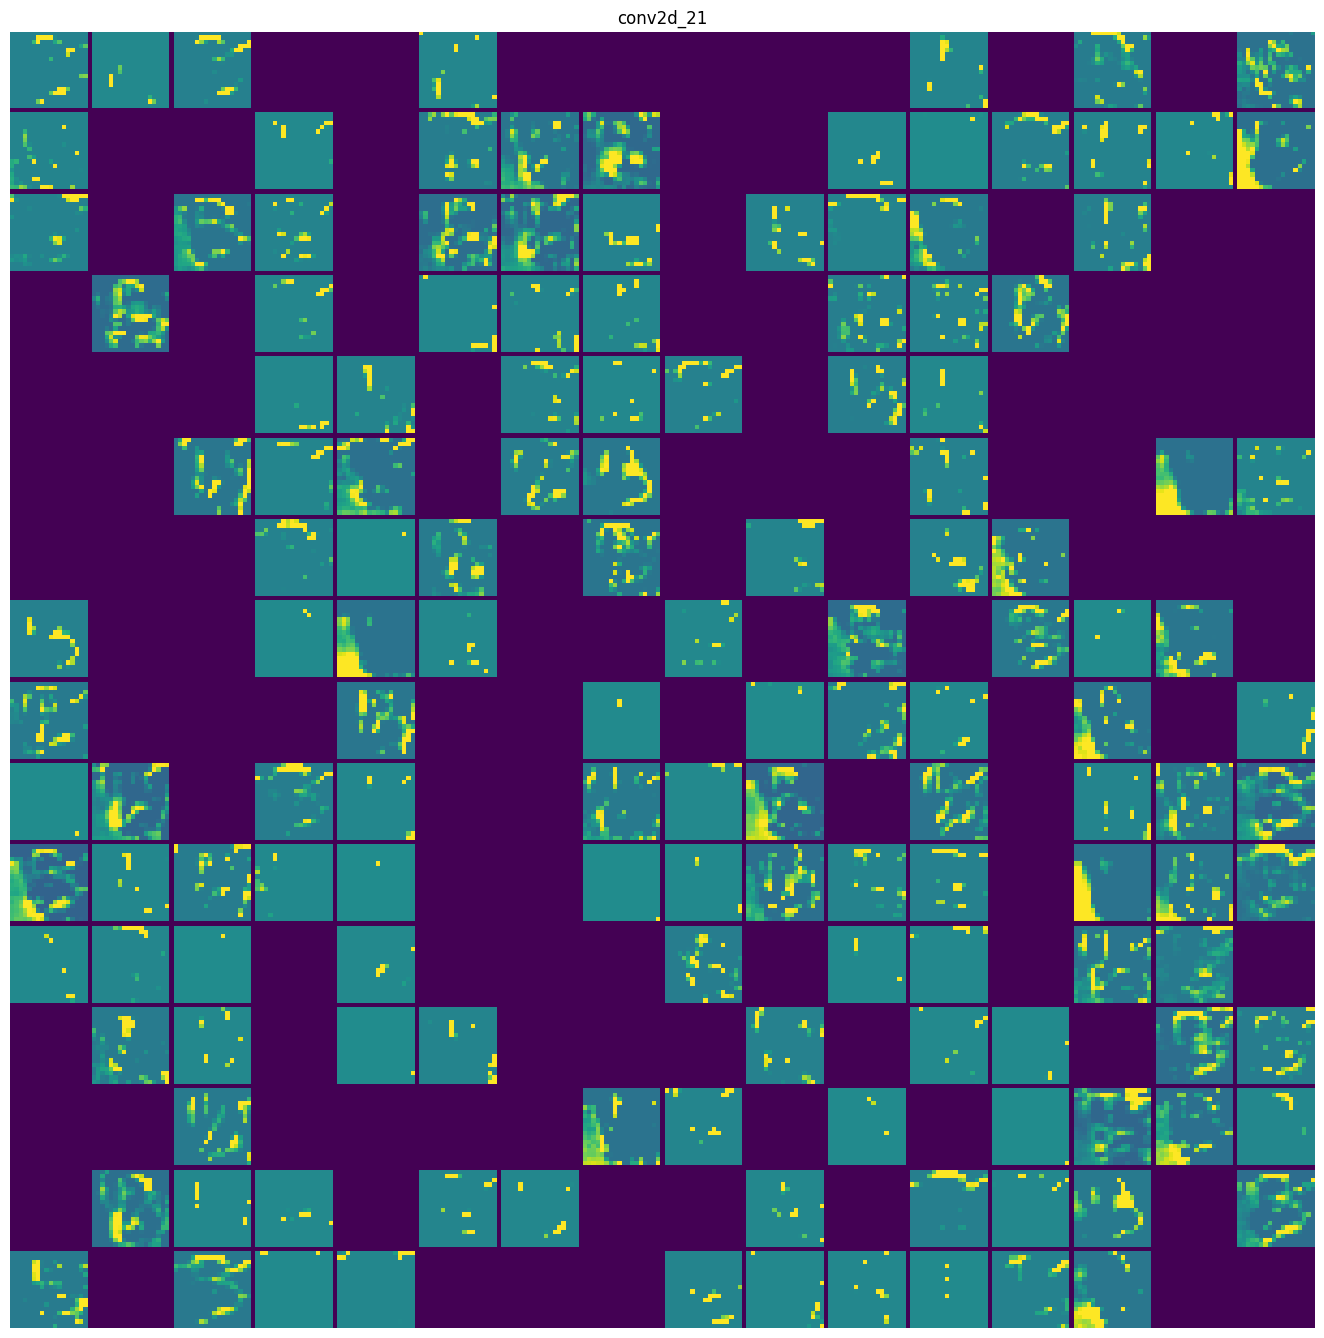

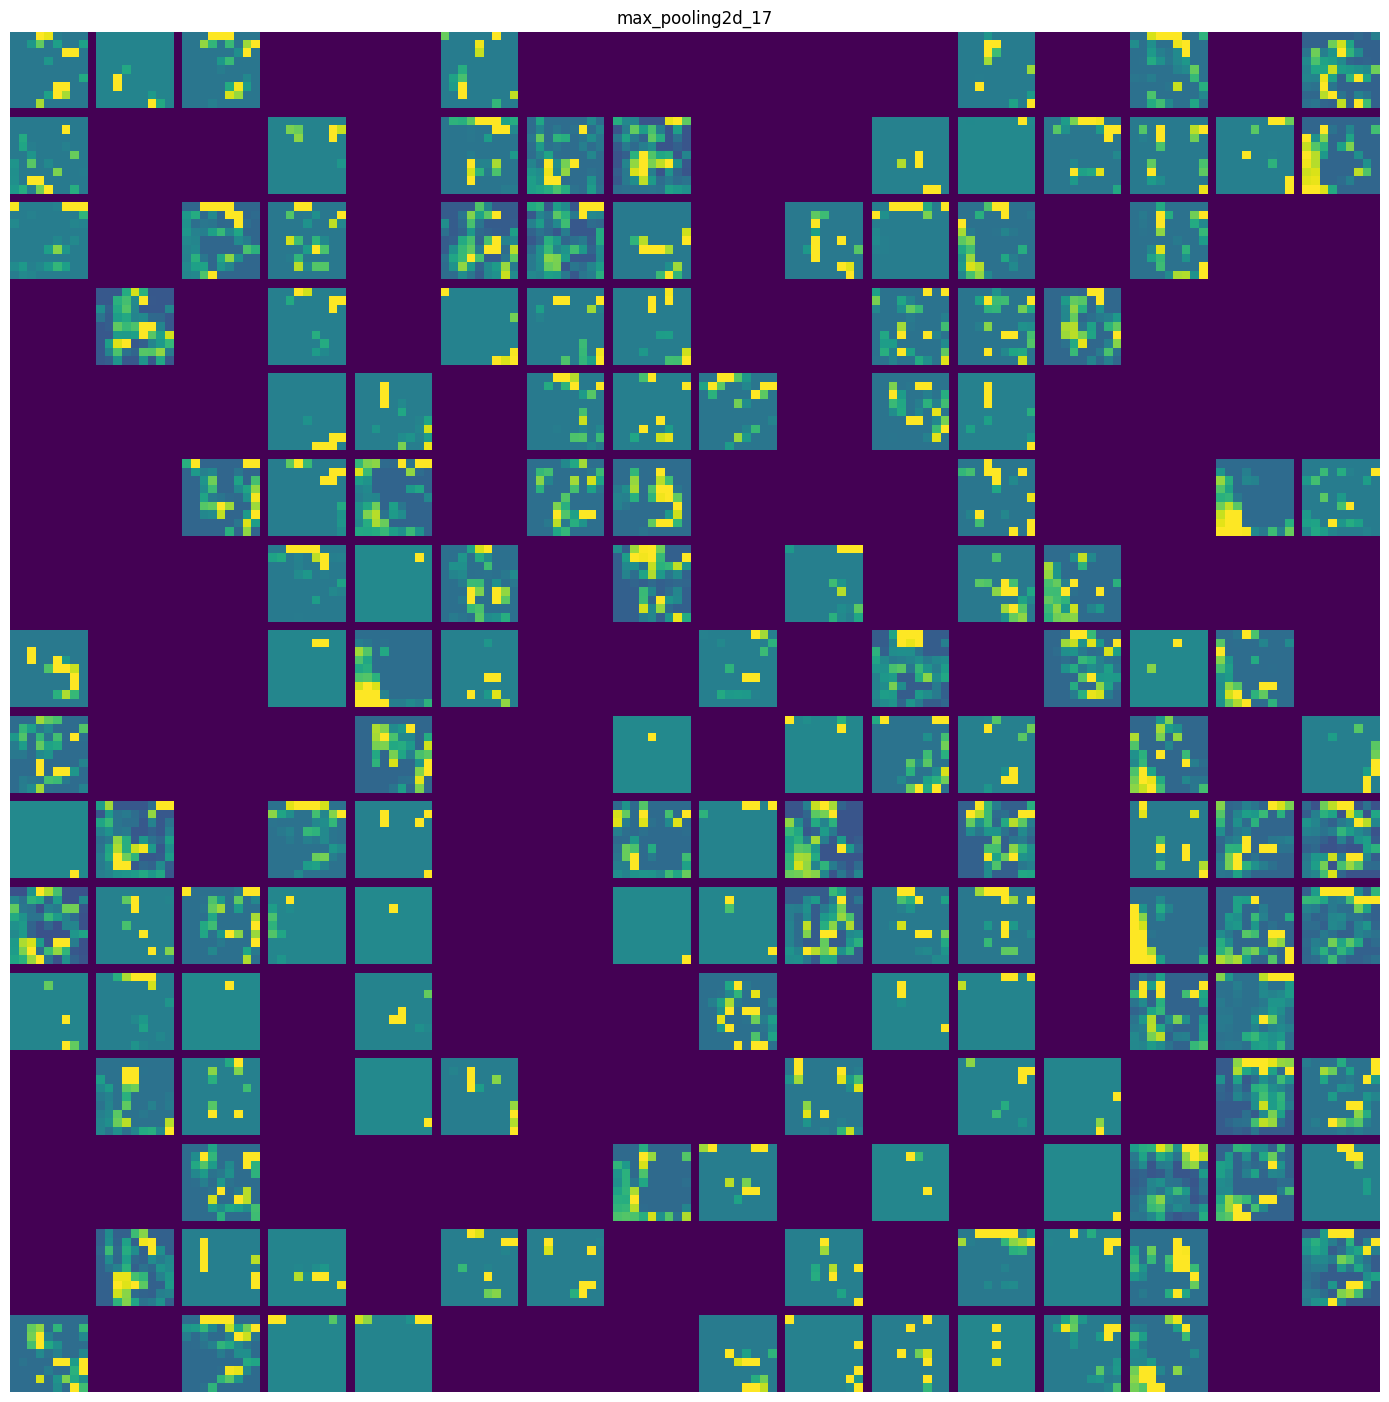

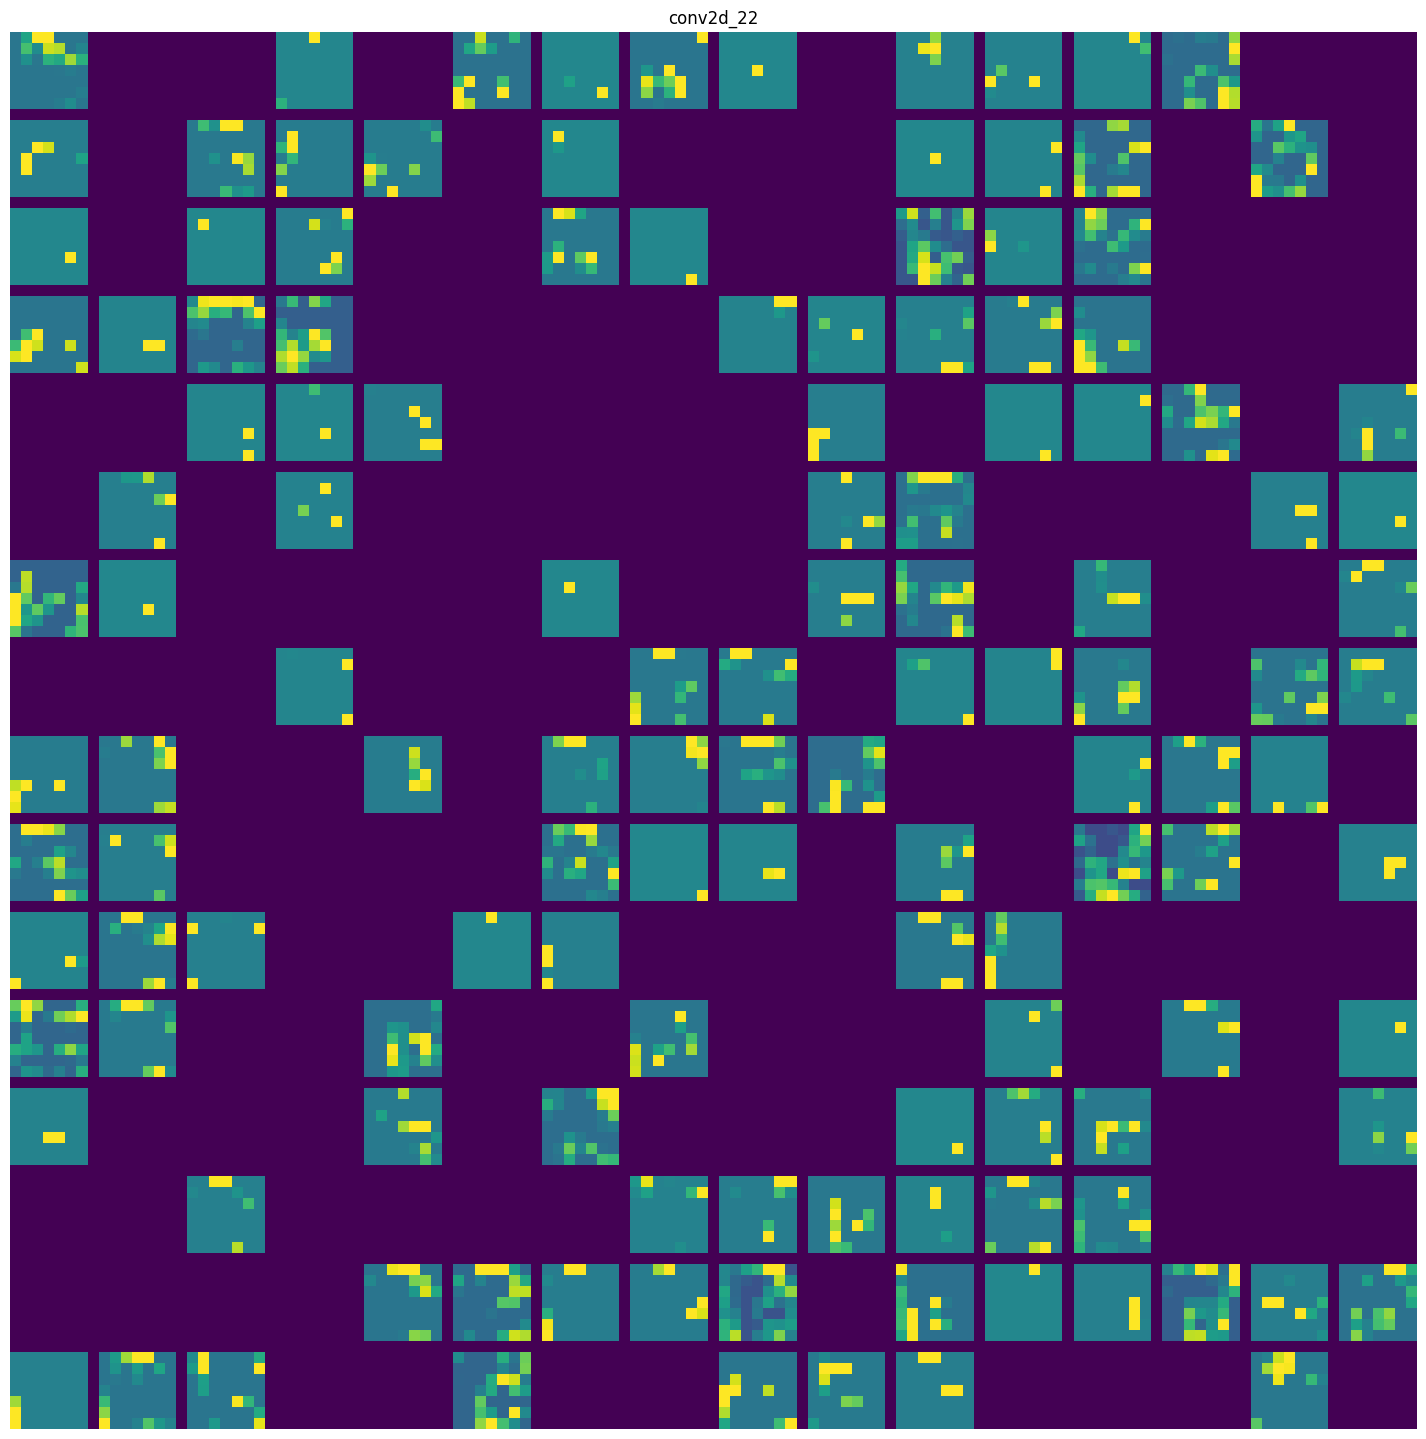

In [31]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_rows = n_features // images_per_row
    display_grid = np.zeros(shape=((size + 1) * n_rows - 1, (size + 1) * images_per_row - 1))

    for row in range(n_rows):
        for col in range(images_per_row):
            channel_index = row * images_per_row + col
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype(np.uint8)
            display_grid[row * (size + 1): (row + 1) * (size + 1) - 1,
                         col * (size + 1): (col + 1) * (size + 1) - 1] = channel_image
    scale = 1 / size

    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [8]:
model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

83683744/83683744 [==============================] - 5s 0us/step


In [11]:
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [41]:
layer_name = 'block3_sepconv1'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

activation = feature_extractor(keras.applications.xception.preprocess_input(img_tensor))

def compute_loss(image, filter_index, layer_name='block1_conv1'):
    layer = model.get_layer(name=layer_name)
    feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # TODO: change edge widths
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(image, filter_index, learning_rate, layer_name='block1_conv1'):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index, layer_name=layer_name)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

img_width = 200
img_height = 200

def generate_filter_pattern(filter_index, layer_name='block1_conv1'):
    n_iterations = 30
    learning_rate = 10
    image = tf.random.uniform(minval=0.4, maxval=0.6, shape=(1, img_width, img_height, 3))
    for i in range(n_iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate, layer_name=layer_name)
    return image[0].numpy()

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype(np.uint8)
    image = image[25:-25, 25:-25, :] # TODO change edge widths
    return image

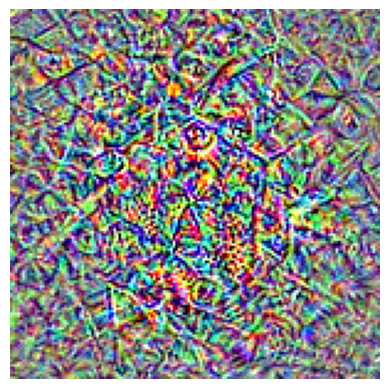

In [59]:
plt.axis('off')
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=0, layer_name='block14_sepconv2')))

In [69]:
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
        layer_name = layer.name
        n_filters = layer.output_shape[-1]
        all_images = []
        for filter_index in range(min(64, n_filters)):
            print(f"Processing filter {filter_index}")
            image = deprocess_image(
                generate_filter_pattern(filter_index, layer_name=layer_name)
            )
            all_images.append(image)

        margin = 5
        n = 8
        cropped_width = img_width - 25 * 2
        cropped_height = img_height - 25 * 2
        width = n * cropped_width + (n - 1) * margin
        height = n * cropped_height + (n - 1) * margin
        stitched_filters = np.zeros((width, height, 3))

        for i in range(min(n_filters // n, n)):
            for j in range(n):
                image = all_images[i * n + j]
                stitched_filters[
                    (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
                    (cropped_height + margin) * j : (cropped_height + margin) * j
                    + cropped_height,
                    :,
                ] = image

        keras.utils.save_img(
            f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing f

In [70]:
model = keras.applications.xception.Xception(weights='imagenet')

91884032/91884032 [==============================] - 6s 0us/step


In [77]:
img_path = keras.utils.get_file(fname='elephant.jpg', origin='https://img-datasets.s3.amazonaws.com/elephant.jpg')

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    a = keras.utils.img_to_array(img)
    a = np.expand_dims(a, axis=0)
    a = keras.applications.xception.preprocess_input(a)
    return a

img_array = get_img_array(img_path, target_size=(299, 299))

In [79]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3))

35363/35363 [==============================] - 0s 0us/step
[[('n02504458', 'African_elephant', 0.8699714), ('n01871265', 'tusker', 0.07692065), ('n02504013', 'Indian_elephant', 0.023575947)]]


In [149]:
last_conv_layer_name = 'block14_sepconv2_act'
classifier_layer_names = []
conv_layer_passed = False
for layer in model.layers:
    if conv_layer_passed:
        classifier_layer_names.append(layer.name)
    if layer.name == last_conv_layer_name:
        conv_layer_passed = True
print(classifier_layer_names)


last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)

classifier_input = layers.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(inputs=classifier_input, outputs=x)

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    predicts = classifier_model(last_conv_layer_output)
    top_predict_index = tf.argmax(predicts[0])
    top_class_channel = predicts[:, top_predict_index]
grads = tape.gradient(top_class_channel, last_conv_layer_output)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

['avg_pool', 'predictions']


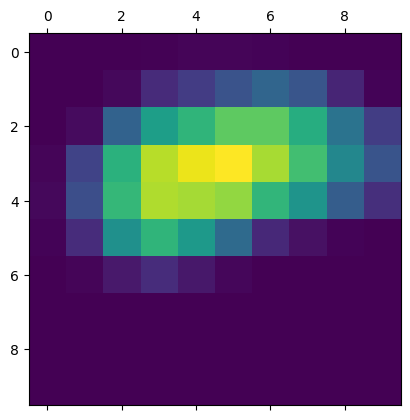

In [150]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

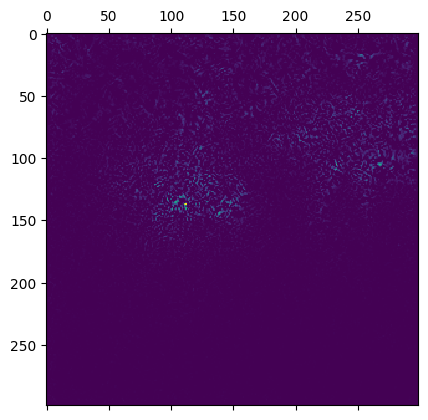

In [157]:
dummy_input = layers.Input(shape=model.input.shape[1:])
dummy_model = keras.Model(inputs=dummy_input, outputs=dummy_input)

with tf.GradientTape() as tape:
    dummy_output = dummy_model(img_array)
    tape.watch(dummy_output)
    predicts = model(dummy_output)
    top_predict_index = tf.argmax(predicts[0])
    top_class_channel = predicts[:, top_predict_index]
grads = tape.gradient(top_class_channel, dummy_output)

heatmap = np.mean(grads[0], axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [158]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

/tmp/ipykernel_13/780671328.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")
